In [ ]:
! git clone -b master https://github.com/tzpranto/NIDS_NSYSS_23

Cloning into 'NIDS-Project'...
remote: Enumerating objects: 865, done.
remote: Counting objects: 100% (610/610), done.
remote: Compressing objects: 100% (466/466), done.
remote: Total 865 (delta 184), reused 567 (delta 143), pack-reused 255
Receiving objects: 100% (865/865), 163.33 MiB | 33.09 MiB/s, done.
Resolving deltas: 100% (314/314), done.


In [ ]:
cd NIDS-Project/

/content/NIDS-Project


In [ ]:
!mkdir Output
!ls

data_generator.py  Dataset_NSLKDD_2  models  Output  training_file.py


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.nn import Linear
from data_generator import get_training_data, dataset_test, dataset_train, cat_dict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
import os, glob
import pickle
from google.colab import files

np.random.seed(12345)
torch.manual_seed(12345)
import random

# 0.01: trainstop 0.005, cluster /25, min_imp_dec: 0.01, (80,100,150) , 5:15PM 26/11/20


random.seed(12345)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
total_dataset, labeled_dataset, unlabeled_dataset = get_training_data(label_ratio=0.5)
test_dataset = dataset_test()
print(total_dataset.get_x().shape)
test_dataset_neg = dataset_test(test_neg=True)

ae_epoch = 80
pretrain_epoch = 200
train_epoch = 150

num_data = total_dataset.get_x()
labels = total_dataset.get_y()

total_original_label_counts = dict()
distinct_labels, distinct_label_counts = np.unique(labels, return_counts=True)
for i in range(len(distinct_labels)):
    if distinct_labels[i] != -1:
        total_original_label_counts[distinct_labels[i]] = distinct_label_counts[i]


# print(total_original_label_counts)


def tree_work(load_cluster_from_file=False):
    if load_cluster_from_file:
        clustering = pickle.load(file=open('models/clustering.pkl', 'rb'))
    else:
        clustering = KMeans(n_clusters=int(total_dataset.__len__() / 175), random_state=0)
        print("Clustering Started.")
        clustering.fit(num_data)
        print("Clustering ended.")

    cluster_assignment = clustering.labels_
    all_clusters = dict()
    for j in range(len(cluster_assignment)):
        all_clusters.setdefault(cluster_assignment[j], []).append(num_data[j])

    cluster_to_label_dict = dict()
    for j in range(len(cluster_assignment)):
        if labels[j] != -1:
            cluster_to_label_dict.setdefault(cluster_assignment[j], []).append(labels[j])

    #print("Clusters:")
    label_to_cluster_dict = dict()
    for k, v in cluster_to_label_dict.items():
        cl_labels, cl_label_counts = np.unique(np.array(v), return_counts=True)  # labeled member count in each cluster
        # print(k)
        # print(cl_labels)
        # print(cl_label_counts)
        # print("\n")
        total_labeled_counts = np.sum(cl_label_counts)

        max_label = np.argmax(cl_label_counts)

        '''
        If a cluster contains more than 10% of all samples of a label present in the training dataset, it is considered
        important for this label.
        If the majority label is not the normal label and there are no other labels for which this cluster is important,
        having more than 50% of the labeled members would be enough for soft labeling
        If the majority label is the normal label, then all labeled members must be normal for soft labeling.
        In any other case, we do not soft label.
        '''

        imp_for_label = []
        for label, total_label_count in total_original_label_counts.items():
            for j in range(len(cl_labels)):
                if cl_labels[j] == label and cl_label_counts[j] > 0.1 * total_label_count:
                    imp_for_label.append(label)

        if (cl_label_counts[max_label] / total_labeled_counts) > 0.5:
            selected_label = cl_labels[max_label]
            if len(imp_for_label) == 1:
                if imp_for_label[0] == selected_label:
                    if selected_label != (int(cat_dict['Normal'])-1):
                        label = selected_label
                        size = len(v)
                        label_to_cluster_dict.setdefault(label, []).append([k, size])
                    else:
                        if len(cl_labels) == 1:
                            label = selected_label
                            size = len(v)
                            label_to_cluster_dict.setdefault(label, []).append([k, size])
            elif len(imp_for_label) == 0:
                if selected_label != (int(cat_dict['Normal'])-1):
                    label = selected_label
                    size = len(v)
                    label_to_cluster_dict.setdefault(label, []).append([k, size])
                else:
                    if len(cl_labels) == 1:
                        label = selected_label
                        size = len(v)
                        label_to_cluster_dict.setdefault(label, []).append([k, size])

    '''
    clusters that belong to a particular label, after soft labeling.
    '''
    soft_label_mapping = dict()
    for k, v in label_to_cluster_dict.items():
        for cluster_index in v:
            soft_label_mapping[cluster_index[0]] = k

    '''
    soft labeling particular unlabeled samples.
    Also add this to labeled dataset.
    '''

    for j in range(len(labels)):
        if labels[j] == -1 and (int(cluster_assignment[j]) in soft_label_mapping.keys()):
            labels[j] = soft_label_mapping[cluster_assignment[j]]
            labeled_dataset.add_sample(num_data[j], labels[j])


    '''
    checking total labeled and soft labeled members.
    '''

    total_soft_label_counts = dict()
    distinct_slabels, distinct_slabel_counts = np.unique(labels, return_counts=True)
    for j in range(len(distinct_slabels)):
        if distinct_slabels[j] != -1:
            total_soft_label_counts[distinct_slabels[j]] = distinct_slabel_counts[j]

    print(total_soft_label_counts)

    cluster_to_labels_dict = dict()
    for k, v in cluster_to_label_dict.items():
        cl_labels = np.unique(np.array(v))
        cl_labels = sorted(list(cl_labels))
        if cl_labels[0] == -1:
            cl_labels = cl_labels[1:]
        cluster_to_labels_dict[k] = cl_labels

    total_dataset.set_y(labels)

    dt_X = labeled_dataset.get_x()
    dt_Y = labeled_dataset.get_y()

    print("labeled members dimensions:")
    print(dt_X.shape)
    print(dt_Y.shape)

    clf = DecisionTreeClassifier(random_state=0, max_leaf_nodes=7)
    clf.fit(dt_X, dt_Y)

    print("No. of leaves of decision tree:")
    print(clf.get_n_leaves())

    '''
    saving decision tree, cluster membership info (this is just to skip the clustering step for our faster use) and soft
    labeling info.
    '''

    file = open('models/tree.pkl', 'wb')
    pickle.dump(clf, file)
    file.close()

    for k in list(all_clusters.keys()):
        if int(k) not in soft_label_mapping.keys():
            soft_label_mapping[int(k)] = (int(cat_dict['Normal'])-1)

    file = open('models/soft_label_mapping.pkl', 'wb')
    pickle.dump(soft_label_mapping, file)
    file.close()

    if not load_cluster_from_file:
        file = open('models/clustering.pkl', 'wb')
        pickle.dump(clustering, file)
        file.close()

    leaf_dataset_X = dict()
    leaf_dataset_Y = dict()

    '''
    finding out corresponding leaf for each training sample.
    '''

    for j in range(len(num_data)):
        leaf = clf.apply([num_data[j]])[0]
        if labels[j] != -1:
            leaf_dataset_X.setdefault(leaf, []).append(num_data[j])
            leaf_dataset_Y.setdefault(leaf, []).append(labels[j])

    for k, v in leaf_dataset_X.items():
        leaf_dataset_X[k] = np.array(leaf_dataset_X[k])
        leaf_dataset_Y[k] = np.array(leaf_dataset_Y[k])

    return leaf_dataset_X, leaf_dataset_Y

'''
The dictionary of X-Y training dataset for each individual leaf.
'''
leaf_dataset_X, leaf_dataset_Y = tree_work(load_cluster_from_file=False)

'''
undercomplete autoencoder for embedding.
'''

class AE(nn.Module):

    def __init__(self, n_input, n_z):
        super(AE, self).__init__()
        # encoder
        self.enc_1 = Linear(n_input, 80)
        self.enc_2 = Linear(80, 50)
        self.z_layer = Linear(50, n_z)

        # decoder
        self.dec_1 = Linear(n_z, 50)
        self.dec_2 = Linear(50, 80)
        self.x_bar_layer = Linear(80, n_input)

    def forward(self, x):
        # encoder
        enc_h1 = F.relu(self.enc_1(x))
        enc_h2 = F.relu(self.enc_2(enc_h1))
        z = self.z_layer(enc_h2)

        # decoder
        dec_h1 = F.relu(self.dec_1(z))
        dec_h2 = F.relu(self.dec_2(dec_h1))
        x_bar = self.x_bar_layer(dec_h2)

        return x_bar, z


def train_ae(epochs, load_from_file=False, save_path='models/train_ae'):
    '''
    train autoencoder
    '''

    model = AE(total_dataset.get_feature_shape(), 32)
    model.to(device)

    ae_train_ds = total_dataset
    training_data_length = int(0.7 * ae_train_ds.__len__())
    validation_data_length = ae_train_ds.__len__() - training_data_length
    training_data, validation_data = torch.utils.data.random_split(ae_train_ds,
                                                                   [training_data_length, validation_data_length])

    print(total_dataset.__len__())
    print(training_data.__len__())
    print(validation_data.__len__())

    train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
    validation_loader = DataLoader(validation_data, batch_size=32, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    min_val_loss = 1000000

    for epoch in range(epochs):
        training_loss = 0.
        validation_loss = 0.
        train_batch_num = 0
        val_batch_num = 0

        model.train()
        for batch_idx, (x, _, idx) in enumerate(train_loader):
            x = x.float()
            x = x.to(device)

            train_batch_num = batch_idx

            optimizer.zero_grad()
            x_bar, z = model(x)
            loss = F.mse_loss(x_bar, x)
            training_loss += loss.item()

            loss.backward()
            optimizer.step()

        training_loss /= (train_batch_num + 1)

        model.eval()
        for batch_idx, (x, _, idx) in enumerate(validation_loader):
            x = x.float()
            x = x.to(device)

            val_batch_num = batch_idx

            x_bar, z = model(x)
            loss = F.mse_loss(x_bar, x)
            validation_loss += loss.item()

        validation_loss /= (val_batch_num + 1)

        if epoch % 1 == 0:
            print(
                "epoch {} , Training loss={:.4f}, Validation loss={:.4f}".format(epoch, training_loss, validation_loss))

        if epoch == 0 or min_val_loss > validation_loss:
            min_val_loss = validation_loss
            torch.save(model.state_dict(), save_path)

    print("model saved to {}.".format(save_path))
    return model


class leaf_dnn(nn.Module):

    def __init__(self, n_input, n_output):
        super(leaf_dnn, self).__init__()
        self.fc1 = nn.Linear(n_input, 8)
        self.fc2 = nn.Linear(8, n_output)

    def forward(self, x):
        out_1 = torch.relu(self.fc1(x))
        out_2 = self.fc2(out_1)

        return out_2

'''
pretraining using labeled and soft labeled dataset.
'''

def pretrain_leaf_dnn(save_path, epochs):
    ae_model = AE(total_dataset.get_feature_shape(), 32)
    ae_model.load_state_dict(torch.load('models/train_ae'))
    ae_model.to(device)

    model = leaf_dnn(32, int(max(labels)) + 1)
    model.to(device)

    weights = torch.FloatTensor(labeled_dataset.get_weight()).to(device)

    train_loader = DataLoader(labeled_dataset, batch_size=32, shuffle=True)  # soft label must be assigned

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    min_train_loss = 1000000

    for epoch in range(epochs):
        train_loss = 0.0
        train_batch_num = 0
        train_num_correct = 0
        train_num_examples = 0

        model.train()
        for batch_idx, (x, y_t, idx) in enumerate(train_loader):
            x = x.float()
            x = x.to(device)
            train_batch_num = batch_idx

            optimizer.zero_grad()

            x_emb = ae_model(x)[1]
            y_pred = model(x_emb)

            y_t = y_t.clone().detach().to(device)

            loss = torch.nn.CrossEntropyLoss(weight=weights)(y_pred, y_t)
            train_loss += loss.item()

            loss.backward()
            optimizer.step()

            correct = torch.eq(torch.max(torch.softmax(y_pred, dim=-1), dim=1)[1], y_t).view(-1)
            train_num_correct += torch.sum(correct).item()
            train_num_examples += correct.shape[0]

        train_loss /= (train_batch_num + 1)
        train_acc = train_num_correct / train_num_examples

        if epoch % 1 == 0:
            print("epoch {}; T loss={:.4f} T Accuracy={:.4f}".
                  format(epoch, train_loss, train_num_correct / train_num_examples))

        if epoch == 0 or min_train_loss > train_loss:
            min_train_loss = train_loss
            torch.save(model.state_dict(), save_path)

    print("model saved to {}.".format(save_path))

    return model



'''
training dataset of an individual leaf.
'''

def train_leaf_dnn(model, dataset, save_path, epochs):
    ae_model = AE(total_dataset.get_feature_shape(), 32)
    ae_model.load_state_dict(torch.load('models/train_ae'))
    ae_model.to(device)

    weights = torch.FloatTensor(dataset.get_weight()).to(device)

    train_loader = DataLoader(dataset, batch_size=32, shuffle=True)  # soft label must be assigned

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    min_train_loss = 1000000
    prev_train_acc = 0
    stop_flag = 1

    for epoch in range(epochs):
        train_loss = 0.0
        train_batch_num = 0
        train_num_correct = 0
        train_num_examples = 0

        model.train()
        for batch_idx, (x, y_t, idx) in enumerate(train_loader):
            x = x.float()
            x = x.to(device)
            train_batch_num = batch_idx

            optimizer.zero_grad()

            x_emb = ae_model(x)[1]
            y_pred = model(x_emb)

            y_t = y_t.clone().detach().to(device)

            loss = torch.nn.CrossEntropyLoss(weight=weights)(y_pred, y_t)
            train_loss += loss.item()

            loss.backward()
            optimizer.step()

            correct = torch.eq(torch.max(torch.softmax(y_pred, dim=-1), dim=1)[1], y_t).view(-1)
            train_num_correct += torch.sum(correct).item()
            train_num_examples += correct.shape[0]

        train_loss /= (train_batch_num + 1)
        train_acc = train_num_correct / train_num_examples

        if epoch % 1 == 0:
            # print("epoch {}; T loss={:.4f} T Accuracy={:.4f}".
            #       format(epoch, train_loss, train_num_correct / train_num_examples))

            if train_acc - prev_train_acc > 0.005:
                    stop_flag = 0


        if epoch == 0 or min_train_loss > train_loss:
            min_train_loss = train_loss
            torch.save(model.state_dict(), save_path)

        if train_acc == 1.0:
            break

        if epoch % 30 == 0:
            if stop_flag == 1:
                break
                # if train_acc > 0.96:
                #     break
                # for g in optimizer.param_groups:
                #     g['lr'] = g['lr']*2
            stop_flag = 1
            prev_train_acc = train_acc

    #print("model saved to {}.".format(save_path))

    return model

'''
training all leaves.
'''

def create_leaf_dnns(remove_priors=True,epochs=150):
    if remove_priors:
        #print("Removing...")
        filelist = glob.glob(os.path.join('models/leaf_models', "*"))
        for f in filelist:
            os.remove(f)

    for key in leaf_dataset_Y.keys():
        dataset_X = leaf_dataset_X[key]
        dataset_Y = leaf_dataset_Y[key]

        # print(key)
        # print(dataset_X.shape)
        # print(dataset_Y.shape)
        # print("\n")

        data = dataset_X, dataset_Y
        dataset = dataset_train(data)

        save_path = "models/leaf_models/leaf_" + str(key)

        model = leaf_dnn(32, int(max(labels)) + 1)
        model.load_state_dict(torch.load('models/pretrain_leaf_dnn'))
        # if os.path.exists(save_path):
        #     model.load_state_dict(torch.load(save_path))
        # else:
        #     print("Loading Pre Trained...")
        #     model.load_state_dict(torch.load('models/pretrain_leaf_dnn'))
        model.to(device)


        train_leaf_dnn(model, dataset, save_path, epochs)


#create_leaf_dnns()


def generate_result():
    clf = pickle.load(file=open('models/tree.pkl', 'rb'))
    soft_label_mapping = pickle.load(file=open('models/soft_label_mapping.pkl', 'rb'))
    clustering = pickle.load(file=open('models/clustering.pkl', 'rb'))

    test_X = test_dataset.get_x()
    test_Y = test_dataset.get_y()

    leaf_nodes = clf.apply(test_X)
    cluster_assignment = clustering.predict(test_X)

    print("done")

    ae_model = AE(total_dataset.get_feature_shape(), 32)
    ae_model.load_state_dict(torch.load('models/train_ae'))
    ae_model.to(device)
    '''
    If model does not exist for a particular leaf, use the default pretrained model.
    '''

    model_dict = dict()
    leaf_model_files = os.listdir('models/leaf_models')
    for file in leaf_model_files:
        spl = str(file).split("_")

        leaf_model = leaf_dnn(32, int(max(labels)) + 1)

        if not os.path.exists('models/leaf_models/leaf_' + spl[1]):
            leaf_model.load_state_dict(torch.load('models/pretrain_leaf_dnn'))
        else:
            leaf_model.load_state_dict(torch.load('models/leaf_models/leaf_' + spl[1]))

        leaf_model.to(device)

        model_dict[int(spl[1])] = leaf_model

    leaf_pred_dict = dict()
    for k, v in model_dict.items():
        leaf_model = v
        X_emb = ae_model(torch.FloatTensor(test_X).to(device))[1]
        Y = torch.softmax(leaf_model(X_emb), dim=-1)
        Y_ = Y.cpu().detach().numpy()
        leaf_pred_dict[k] = Y_

    test_Y_pred = np.zeros(test_Y.shape)

    for j in range(len(leaf_nodes)):
        y_ = leaf_pred_dict[leaf_nodes[j]][j]
        if soft_label_mapping[cluster_assignment[j]] != cat_dict['Normal']:
            y_[int(cat_dict['Normal'])] = 0
        y_pred = np.argmax(y_)
        test_Y_pred[j] = y_pred

    print(confusion_matrix(test_Y, test_Y_pred))
    print(classification_report(test_Y, test_Y_pred))

    test_Y_df = pd.DataFrame(test_Y, columns=['True Label'])
    pred_Y_df = pd.DataFrame(test_Y_pred, columns=['Pred Label'])
    result = pd.concat([test_Y_df,pred_Y_df],axis=1, sort=False)
    #result.to_csv('Output/result-frac-10'+'.csv', index=False)
    #files.download('Output/result-frac-10'+'.csv')


def generate_test_result():
    clf = pickle.load(file=open('models/tree.pkl', 'rb'))
    soft_label_mapping = pickle.load(file=open('models/soft_label_mapping.pkl', 'rb'))
    clustering = pickle.load(file=open('models/clustering.pkl', 'rb'))

    test_X = test_dataset.get_x()
    test_Y = test_dataset.get_y()

    leaf_nodes = clf.apply(test_X)
    cluster_assignment = clustering.predict(test_X)

    print("done")

    ae_model = AE(total_dataset.get_feature_shape(), 32)
    ae_model.load_state_dict(torch.load('models/train_ae'))
    ae_model.to(device)
    '''
    If model does not exist for a particular leaf, use the default pretrained model.
    '''

    model_dict = dict()
    leaf_model_files = os.listdir('models/leaf_models')
    for file in leaf_model_files:
        spl = str(file).split("_")

        leaf_model = leaf_dnn(32, int(max(labels)) + 1)

        if not os.path.exists('models/leaf_models/leaf_' + spl[1]):
            leaf_model.load_state_dict(torch.load('models/pretrain_leaf_dnn'))
        else:
            leaf_model.load_state_dict(torch.load('models/leaf_models/leaf_' + spl[1]))

        leaf_model.to(device)

        model_dict[int(spl[1])] = leaf_model

    leaf_pred_dict = dict()
    for k, v in model_dict.items():
        leaf_model = v
        X_emb = ae_model(torch.FloatTensor(test_X).to(device))[1]
        Y = torch.softmax(leaf_model(X_emb), dim=-1)
        Y_ = Y.cpu().detach().numpy()
        leaf_pred_dict[k] = Y_

    test_Y_pred = np.zeros(test_Y.shape)

    for j in range(len(leaf_nodes)):
        y_ = leaf_pred_dict[leaf_nodes[j]][j]
        if soft_label_mapping[cluster_assignment[j]] != (int(cat_dict['Normal'])-1):
            y_[(int(cat_dict['Normal'])-1)] = 0
        y_pred = np.argmax(y_)
        test_Y_pred[j] = y_pred

    return accuracy_score(test_Y, test_Y_pred)


def generate_train_result():
    clf = pickle.load(file=open('models/tree.pkl', 'rb'))
    soft_label_mapping = pickle.load(file=open('models/soft_label_mapping.pkl', 'rb'))
    clustering = pickle.load(file=open('models/clustering.pkl', 'rb'))

    dataset, _ , _ = get_training_data(label_ratio=1.0)

    test_X = dataset.get_x()
    test_Y = dataset.get_y()

    leaf_nodes = clf.apply(test_X)
    cluster_assignment = clustering.predict(test_X)

    print("done")

    ae_model = AE(total_dataset.get_feature_shape(), 32)
    ae_model.load_state_dict(torch.load('models/train_ae'))
    ae_model.to(device)
    '''
    If model does not exist for a particular leaf, use the default pretrained model.
    '''

    model_dict = dict()
    leaf_model_files = os.listdir('models/leaf_models')
    for file in leaf_model_files:
        spl = str(file).split("_")

        leaf_model = leaf_dnn(32, int(max(labels)) + 1)

        if not os.path.exists('models/leaf_models/leaf_' + spl[1]):
            leaf_model.load_state_dict(torch.load('models/pretrain_leaf_dnn'))
        else:
            leaf_model.load_state_dict(torch.load('models/leaf_models/leaf_' + spl[1]))

        leaf_model.to(device)

        model_dict[int(spl[1])] = leaf_model

    leaf_pred_dict = dict()
    for k, v in model_dict.items():
        leaf_model = v
        X_emb = ae_model(torch.FloatTensor(test_X).to(device))[1]
        Y = torch.softmax(leaf_model(X_emb), dim=-1)
        Y_ = Y.cpu().detach().numpy()
        leaf_pred_dict[k] = Y_

    test_Y_pred = np.zeros(test_Y.shape)

    for j in range(len(leaf_nodes)):
        y_ = leaf_pred_dict[leaf_nodes[j]][j]
        if soft_label_mapping[cluster_assignment[j]] != (int(cat_dict['Normal'])-1):
            y_[(int(cat_dict['Normal'])-1)] = 0
        y_pred = np.argmax(y_)
        test_Y_pred[j] = y_pred

    return accuracy_score(test_Y, test_Y_pred)


train_ae(ae_epoch, False)
pretrain_leaf_dnn('models/pretrain_leaf_dnn', pretrain_epoch)
create_leaf_dnns()
generate_result()


# train_accuracies = []
# test_accuracies = []
# # for i in range(150):
# #     create_leaf_dnns(remove_priors=True,epochs=i+1)
# #     train_accuracies.append(generate_train_result())
# #     test_accuracies.append(generate_test_result())
# #     print('Epoch: '+str(i)+' -> '+str(train_accuracies[i])+'\t'+str(test_accuracies[i]))

# train_ae(ae_epoch, False)

# j = 0
# for i in range(5,201,5):
#     pretrain_leaf_dnn('models/pretrain_leaf_dnn', i)
#     create_leaf_dnns(remove_priors=True,epochs=150)
#     train_accuracies.append(generate_train_result())
#     test_accuracies.append(generate_test_result())
#     print('Epoch: '+str(i)+' -> '+str(train_accuracies[j])+'\t'+str(test_accuracies[j]))
#     j = j+1


# train_accuracies = np.array(train_accuracies)
# test_accuracies = np.array(test_accuracies)

# train_accuracies_df = pd.DataFrame(train_accuracies, columns=['Train Accuracy'])
# test_accuracies_df = pd.DataFrame(test_accuracies, columns=['Test Accuracy'])
# result = pd.concat([train_accuracies_df,test_accuracies_df], axis=1,sort=False )
# result.to_csv('Output/pre-accuracies-frac-100'+'.csv', index=False)
# from google.colab import files
# files.download('Output/pre-accuracies-frac-100'+'.csv')




(25192, 118)
Clustering Started.
Clustering ended.
{0.0: 105, 1.0: 6876, 2.0: 13353, 3.0: 5, 4.0: 2144}
labeled members dimensions:
(22483, 118)
(22483,)
No. of leaves of decision tree:
7
25192
17634
7558
epoch 0 , Training loss=0.7018, Validation loss=0.5154
epoch 1 , Training loss=0.4727, Validation loss=0.3719
epoch 2 , Training loss=0.3679, Validation loss=0.2882
epoch 3 , Training loss=0.3055, Validation loss=0.2379
epoch 4 , Training loss=0.2672, Validation loss=0.2084
epoch 5 , Training loss=0.2418, Validation loss=0.1885
epoch 6 , Training loss=0.2257, Validation loss=0.1650
epoch 7 , Training loss=0.2110, Validation loss=0.1560
epoch 8 , Training loss=0.2022, Validation loss=0.1534
epoch 9 , Training loss=0.1947, Validation loss=0.1523
epoch 10 , Training loss=0.1920, Validation loss=0.1481
epoch 11 , Training loss=0.1851, Validation loss=0.1460
epoch 12 , Training loss=0.1788, Validation loss=0.1398
epoch 13 , Training loss=0.1760, Validation loss=0.1424
epoch 14 , Training l

In [ ]:
def black_box_test(x):
    clf = pickle.load(file=open('models/tree.pkl', 'rb'))
    soft_label_mapping = pickle.load(file=open('models/soft_label_mapping.pkl', 'rb'))
    clustering = pickle.load(file=open('models/clustering.pkl', 'rb'))

    leaf_nodes = clf.apply(x)
    cluster_assignment = clustering.predict(x)

    #print("done")

    ae_model = AE(total_dataset.get_feature_shape(), 32)
    ae_model.load_state_dict(torch.load('models/train_ae'))
    ae_model.to(device)
    '''
    If model does not exist for a particular leaf, use the default pretrained model.
    '''

    model_dict = dict()
    leaf_model_files = os.listdir('models/leaf_models')
    for file in leaf_model_files:
        spl = str(file).split("_")

        leaf_model = leaf_dnn(32, int(max(labels)) + 1)

        if not os.path.exists('models/leaf_models/leaf_' + spl[1]):
            leaf_model.load_state_dict(torch.load('models/pretrain_leaf_dnn'))
        else:
            leaf_model.load_state_dict(torch.load('models/leaf_models/leaf_' + spl[1]))

        leaf_model.to(device)

        model_dict[int(spl[1])] = leaf_model

    leaf_pred_dict = dict()
    for k, v in model_dict.items():
        leaf_model = v
        X_emb = ae_model(torch.FloatTensor(test_X).to(device))[1]
        Y = torch.softmax(leaf_model(X_emb), dim=-1)
        Y_ = Y.cpu().detach().numpy()
        leaf_pred_dict[k] = Y_

    test_Y_pred = np.zeros(test_Y.shape)

    for j in range(len(leaf_nodes)):
        y_ = leaf_pred_dict[leaf_nodes[j]][j]
        if soft_label_mapping[cluster_assignment[j]] != int(cat_dict['Normal']):
            y_[int(cat_dict['Normal'])-1] = 0
        y_pred = np.argmax(y_)
        test_Y_pred[j] = y_pred
    return test_Y_pred

def getBinPrediction(pred_Y):
    bin_pred_y = []
    for y in pred_Y:
        if y != (int(cat_dict['Normal'])-1):
            bin_pred_y.append(1)
        else:
            bin_pred_y.append(0)
    return bin_pred_y

In [ ]:
print(int(cat_dict['Normal'])-1)

1


In [ ]:
test_X = test_dataset.get_x()
test_Y = test_dataset.get_y()

pred_Y = black_box_test(test_X)
bin_pred_y = getBinPrediction(pred_Y)
print(accuracy_score(test_Y, pred_Y))


print(len(pred_Y))
print(np.sum(np.array(bin_pred_y)))

0.5461320085166785
22544
22180


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=False,
                          figsize=None,
                          cmap='Blues',
                          title=None,
                          download=True):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            tpr = cf[0,0] / np.sum(cf[0])
            fpr = cf[1,0]/np.sum(cf[1])
            stats_text = "\n\nAccuracy={:0.3f}\nTrue Positive Rate={:0.3f}\nFalse Postitive Rate={:0.3f}".format(
                accuracy,tpr,fpr)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)
    if download:
        plt.savefig("cm_bin_2.png")
        files.download('cm_bin_2.png')

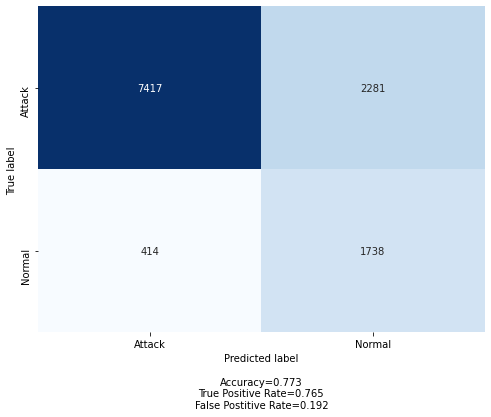

In [ ]:
categories = ['R2L', 'DoS', 'Normal', 'U2R', 'Probe']
matrix_1 = np.array([[ 845,   22, 1130,   35,  722],
 [ 358, 6236,  722,   16,  126],
 [  38,   63, 9260,   50,  300],
 [  45,   12,  100,  26,   17],
 [  41,  138,  330,   25, 1887]])

matrix_2 = np.array([[ 845,   22, 1130,   35,  722],
 [ 358, 3208,  721,    6,   49],
 [  27,   61, 1738,   33,  293],
 [  45,   12,  100,   26,   17],
 [  41,  138,  330,   25, 1868]])

tn = matrix_2[2][2]
fp = np.sum(matrix_2[2]) - tn
fn = matrix_2[0][2] + matrix_2[1][2] + matrix_2[3][2] + matrix_2[4][2]
tp = np.sum(matrix_2) - tn - fn - fp
matrix_3 = np.array([[tp,fn],[fp,tn]])

tn = matrix_1[2][2]
fp = np.sum(matrix_1[2]) - tn
fn = matrix_1[0][2] + matrix_1[1][2] + matrix_2[3][2] + matrix_2[4][2]
tp = np.sum(matrix_1) - tn - fn - fp
matrix_4 = np.array([[tp,fn],[fp,tn]])

categories = ['Attack','Normal']
make_confusion_matrix(matrix_3, figsize=(8,6), cbar=False, categories=categories, percent=False, download=False, sum_stats=True)
